# Import

In [37]:
import os
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

In [38]:
df = pd.read_csv("data/bilan-electrique.csv")

In [39]:
df.head()

,Unnamed: 0,datasetid,recordid,record_timestamp,injection_rte,pertes,consommation_hta,soutirage_rte,production_profilee_photovoltaique,temperature_normale_lissee,...,consommation_profilee,production_profilee_aut,consommation_totale,mois,consommation_profilee_ent_hta,pseudo_rayonnement,soutirage_vers_autres_grd,horodate,consommation_telerelevee,production_photovoltaique
0,0,bilan-electrique-demi-heure,58084cf1db47bd052687d2808114953d19755216,2023-05-16T01:00:01.115Z,3.182218e+10,2.099434e+09,9.991167e+09,555480000.0,4304.0,14.3,...,1.851374e+10,1745767.0,3.177138e+10,5,9456817.0,57,290227009.0,2023-05-05T21:30:00+00:00,1.325764e+10,2060926.0
1,1,bilan-electrique-demi-heure,a0f3d1fa216f68beb1ba355e92718bb6582e7f88,2023-05-16T01:00:01.115Z,3.230077e+10,2.125454e+09,1.013050e+10,570125000.0,4608.0,14.3,...,1.866496e+10,1745767.0,3.219705e+10,5,9779855.0,57,288823000.0,2023-05-05T21:00:00+00:00,1.353209e+10,2153851.0
2,2,bilan-electrique-demi-heure,4abd9b6184d9c90f8ec85e3558fcac979e893297,2023-05-16T01:00:01.115Z,3.280950e+10,2.154360e+09,1.025865e+10,537333000.0,10363.0,14.4,...,1.884364e+10,1745767.0,3.264346e+10,5,10073269.0,56,282280700.0,2023-05-05T20:30:00+00:00,1.379982e+10,2176151.0
3,3,bilan-electrique-demi-heure,07382d88805d5a4ee9588fd6ff27c57af3630296,2023-05-16T01:00:01.115Z,3.122503e+10,2.003898e+09,1.036766e+10,477538000.0,10724.0,14.6,...,1.709235e+10,1745767.0,3.114739e+10,5,10514334.0,55,247365075.0,2023-05-05T20:00:00+00:00,1.405504e+10,2423144.0
4,4,bilan-electrique-demi-heure,ccf92afe83d1d3540f6cec6e79a574fd41992624,2023-05-16T01:00:01.115Z,3.107709e+10,1.987082e+09,1.038233e+10,452558000.0,7828.0,14.7,...,1.689479e+10,1745767.0,3.097478e+10,5,9587642.0,54,247766841.0,2023-05-05T19:30:00+00:00,1.407998e+10,2581626.0


## Create the model

The task is to predict a week (168 hours) of consumption. 2 approaches can be used with deep neural networks. We can either predict a single timestamp (next hour) with a given sequence and repeat the process with the predicted timestamp or directly predict the 168 hours from a given sequence with a sequence to sequence model. Predicting a single timestamp and then feeding the prediction back into the model for a week can be simpler in terms of model architecture, but it might lead to the propagation of errors. Since each prediction is used as input for the next prediction, errors can accumulate rapidly. This is especially true for long sequence predictions like a week (168 hours).On the other hand, directly predicting the next week's worth of data (sequence prediction) can potentially be more accurate since it can leverage information from all input at once. But the model architecture can be more complex, and the training might be more difficult and computationally expensive. Plus, it might overfit to specific sequences length and not generalize well to other lengths.

Here we have chosen to implement the simple model predicting only the next timestamp.

In [43]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
    
        # Modifying this line to use the last hidden state
        out = self.fc(hidden[-1])
    
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

## Prepare the data

In [44]:
def create_sequences(data, sequence_length, pred_len=1):
    x = []
    y = []
    for i in range(len(data)-sequence_length-pred_len+1):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+pred_len])
    return np.array(x), np.array(y)

In [45]:
from datetime import datetime
import time
from sklearn.model_selection import train_test_split

def preprocess_data(file_path, sequence_length=186, output_seq_len=1, split_ratio=0.8, batch_size=32):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    df['horodate'] = pd.to_datetime(df['horodate'])
    df = df.set_index('horodate')
    data = df['consommation_hta'].values.reshape(-1, 1)
    
    # Normalize the 'consommation_hta' data with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    
    x, y = create_sequences(data, sequence_length, output_seq_len)  # pass output_seq_len here
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-split_ratio, random_state=42)

    # Convert to Tensors and create data loaders
    train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    
    return train_loader, test_loader, scaler

## Train the model

In [58]:
import matplotlib.pyplot as plt
import tqdm

def train_model(model, train_loader, test_loader, num_epochs, learning_rate, patience=5):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss_list = []
    test_loss_list = []

    best_loss = float('inf')
    no_improve_epoch = 0

    for epoch in tqdm.tqdm(range(num_epochs), desc='Training the model', unit='epoch', total=num_epochs):
        
        train_loss = 0
        for inputs, targets in train_loader:
            output = model(inputs)
            targets = targets[:,0,:]
            loss = criterion(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
            
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                output = model(inputs)
                targets = targets[:,0,:]
                loss = criterion(output, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, test_loss))

        # check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                print('Early stopping')
                break

    # Plot training and testing loss
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.legend()
    plt.show()

    return model


In [105]:
# Set the input sequence length to one week (168 hours)
input_seq_len = 24*6
output = 1
# Initialize the encoder and decoder
model = Model(input_size=1, output_size=output, hidden_dim=128, n_layers=3)

# Set the number of training epochs and learning rate
num_epochs = 1000
learning_rate = 0.00001

# Get the data loaders
file_path = "data/bilan-electrique.csv"
train_loader, test_loader, scaler = preprocess_data(file_path, sequence_length=input_seq_len, output_seq_len=output, batch_size=32)

# Train the model
model = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

Training the model:   0%|          | 1/1000 [00:09<2:31:24,  9.09s/epoch]

Epoch [1/1000], Loss: 0.1359, Test Loss: 0.0476


Training the model:   0%|          | 2/1000 [00:18<2:32:57,  9.20s/epoch]

Epoch [2/1000], Loss: 0.0336, Test Loss: 0.0244


Training the model:   0%|          | 3/1000 [00:27<2:33:41,  9.25s/epoch]

Epoch [3/1000], Loss: 0.0173, Test Loss: 0.0125


Training the model:   0%|          | 4/1000 [00:37<2:34:41,  9.32s/epoch]

Epoch [4/1000], Loss: 0.0100, Test Loss: 0.0091


Training the model:   0%|          | 5/1000 [00:46<2:35:21,  9.37s/epoch]

Epoch [5/1000], Loss: 0.0076, Test Loss: 0.0073


Training the model:   1%|          | 6/1000 [00:56<2:36:04,  9.42s/epoch]

Epoch [6/1000], Loss: 0.0061, Test Loss: 0.0060


Training the model:   1%|          | 7/1000 [01:05<2:35:40,  9.41s/epoch]

Epoch [7/1000], Loss: 0.0051, Test Loss: 0.0051


Training the model:   1%|          | 8/1000 [01:15<2:36:48,  9.48s/epoch]

Epoch [8/1000], Loss: 0.0044, Test Loss: 0.0044


Training the model:   1%|          | 9/1000 [01:24<2:36:38,  9.48s/epoch]

Epoch [9/1000], Loss: 0.0038, Test Loss: 0.0039


# Show the prediction of our model

In [95]:
def forecast(model, df, sequence_length, scaler, to_predict):
    # Extract the last week data and scale it
    last_week = df['consommation_hta'].values[-(sequence_length+to_predict):].reshape(-1, 1)
    last_week_scaled = scaler.transform(last_week)
    print(last_week.shape)
    model.eval()  # set the model to evaluation mode
    predicted = []  # list to store the predicted values
    real = []  # list to store the real values
    first_seq = last_week_scaled[:-to_predict]
    sequence = first_seq
    with torch.no_grad():
        # Start predicting the next week consumption hour by hour
        for i in range(to_predict):  # 24 hours * 7 days = 168 hours
            sequence = torch.FloatTensor(sequence)  # get the last sequence_length values
            sequence = sequence.unsqueeze(0)  # add a batch dimension
            prediction = model(sequence)  # make a prediction
            predicted_value = prediction[0, -1].item()  # get the last value (last hour prediction)
            predicted.append(scaler.inverse_transform([[predicted_value]]))  # reverse the scaling and append the prediction to the list
            
            # Append the real value to the list
            try:
                real_value = df['consommation_hta'].values[i-(to_predict)]
                real.append(real_value)
            except IndexError:  # if we've stepped out of the dataset boundaries (means we're predicting the future values)
                real.append(None)
            
            # replace in sequence the first value with the predicted value
            sequence = sequence.squeeze(0)
            sequence = sequence[1:]
            sequence = torch.cat([sequence, torch.FloatTensor([[predicted_value]])], dim=0)
            
    # Flatten the predicted list to have 1D list
    predicted = [item[0][0] for item in predicted]
    
    return predicted, real


In [102]:
time_to_predict = 24*6
predicted, real = forecast(model, df, input_seq_len, scaler, to_predict = time_to_predict)
print(len(predicted))
print(len(real))

(240, 1)
168
168


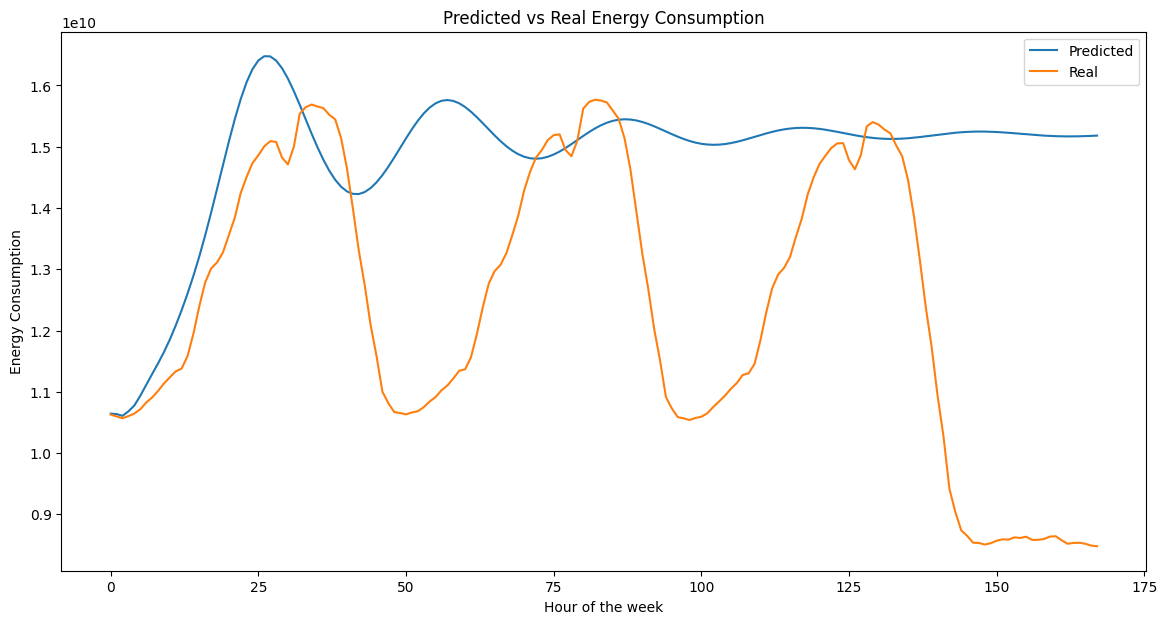

In [104]:
# Create the x axis. It represents the hour of the week from 0 to 168
x = list(range(0, time_to_predict))
# Plot the predicted and real values
plt.figure(figsize=(14, 7))
plt.plot(x, predicted, label='Predicted')
plt.plot(x, real, label='Real')
plt.title('Predicted vs Real Energy Consumption')
plt.xlabel('Hour of the week')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
